# Aim

Get good and fast PSF fitting working, with the current models, in Python 3.8+. This could be using Theano, tf2+, or pytorch, and probably won't be using scipy.

1. (in the `oldeleanor` env) run code from master to show the baseline of fitting works
2. (in the `eleanorupgrade` env) set up frame-by-frame fitting in a new language, for sim data
3. the same as above for real data
4. set up all-at-once fitting using different weights for fluxes, and deviation-from-aperture regularization for coherence
5. the same as above for real data

In [246]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
from scipy.special import iv
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True, 
    do_psf=False,
)

In [109]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, verbose=True, bkg_mag_cutoff=10, ignore_pixels=1)

100%|██████████| 900/900 [03:07<00:00,  4.79it/s]


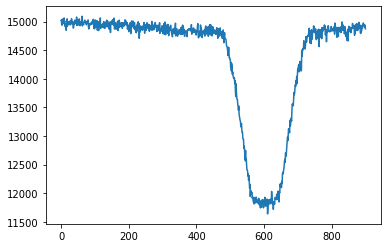

In [110]:
plt.plot(data.psf_flux[:,1])

In [122]:
tpfs_t = torch.tensor(tpfs.astype(np.float32))
errs_t = torch.tensor(errs.astype(np.float32))

In [148]:
prf = eleanor.make_prf_from_source(star)

In [158]:
prf.shape

(117, 117)

In [446]:
x, y = np.meshgrid(range(117), range(117)) 
y -= (117 // 2)
x -= (117 // 2)

In [447]:
y

array([[-58, -58, -58, ..., -58, -58, -58],
       [-57, -57, -57, ..., -57, -57, -57],
       [-56, -56, -56, ..., -56, -56, -56],
       ...,
       [ 56,  56,  56, ...,  56,  56,  56],
       [ 57,  57,  57, ...,  57,  57,  57],
       [ 58,  58,  58, ...,  58,  58,  58]])

In [452]:
def gaussian(pars):
    amp, a, b, c, bkg = pars
    return amp * np.exp(-(a * x ** 2  + 2 * b * x * y + c * y ** 2)) + bkg

def moffat(pars):
    amp, a, b, c, beta, bkg = pars
    psf = amp / (1 + (a ** 2 * x ** 2 + 2 * b * x * y + c ** 2 * y ** 2) ** beta) + bkg
    return psf# / np.sum(psf)

def airy(pars):
    # doesn't work yet
    amp, Rn, bkg = pars
    bessel_arg = np.pi * np.sqrt(x ** 2 + y ** 2) / Rn
    return amp * (2 * iv(1, bessel_arg) / bessel_arg) ** 2

def get_loss(model, prf):
    return lambda pars: np.sum((model(pars) - prf) ** 2)

In [453]:
loss = get_loss(moffat, prf)
res = sopt.minimize(loss, [1, 1, 0.1, 1, 0.5, 0], tol=1e-4)
res

      fun: 0.09069412711381306
 hess_inv: array([[ 1.10893302e-02,  4.21718649e-03, -9.54953146e-05,
         4.78879252e-03, -8.49661558e-02, -2.16861071e-04],
       [ 4.21718649e-03,  3.21646501e-03, -6.44902416e-05,
         1.53691301e-03, -4.49850127e-02, -5.88675692e-05],
       [-9.54953146e-05, -6.44902416e-05,  5.44148552e-05,
        -7.80550732e-05,  6.80109662e-04,  6.00341245e-08],
       [ 4.78879252e-03,  1.53691301e-03, -7.80550732e-05,
         3.88693031e-03, -4.78729989e-02, -6.45315128e-05],
       [-8.49661558e-02, -4.49850127e-02,  6.80109662e-04,
        -4.78729989e-02,  1.58945843e+00,  4.42166410e-03],
       [-2.16861071e-04, -5.88675692e-05,  6.00341245e-08,
        -6.45315128e-05,  4.42166410e-03,  5.68539537e-05]])
      jac: array([ 1.62981451e-05, -2.82591209e-05,  5.37279993e-05,  2.60667875e-05,
        8.53091478e-07,  2.75857747e-05])
  message: 'Optimization terminated successfully.'
     nfev: 336
      nit: 40
     njev: 48
   status: 0
  succes

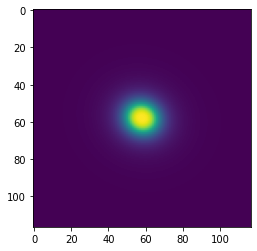

In [454]:
plt.imshow(moffat(res.x))

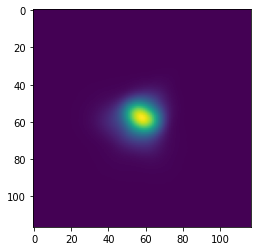

In [455]:
plt.imshow(prf)

Text(0.5, 1.0, '0.09069412711381306')

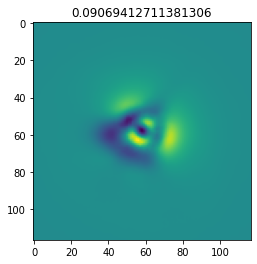

In [456]:
plt.imshow(moffat(res.x) - prf)
plt.title(loss(res.x))

In [282]:
eleanor.models.Zernike

eleanor.models.Zernike

In [287]:
sources_in_tpf = eleanor.mast.gaia_sources_in_tpf(star, 10, tpfs.shape[1:])
xc = np.array(sources_in_tpf.coords_x) + tpfs.shape[2] / 2
yc = np.array(sources_in_tpf.coords_y) + tpfs.shape[1] / 2

In [409]:
from zernike import RZern, FitZern

In [457]:
pol = RZern(6)
L, K = 117, 117
ip = FitZern(pol, L, K)
pol.make_pol_grid(ip.rho_j, ip.theta_i)

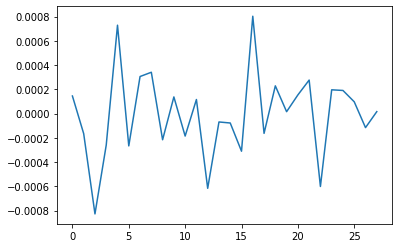

In [458]:
coeffs = ip.fit((moffat(res.x) - prf).flatten())
plt.plot(coeffs)

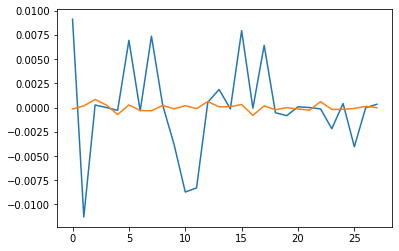

In [459]:
plt.plot(ip.fit(moffat(res.x).flatten()))
plt.plot(ip.fit(prf.flatten()) - ip.fit(moffat(res.x).flatten()))


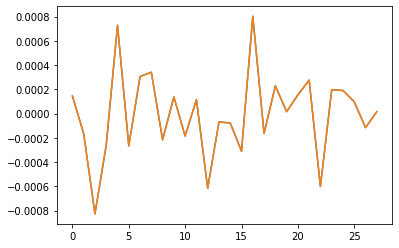

In [461]:
plt.plot(-ip.fit(prf.flatten()) + ip.fit(moffat(res.x).flatten()))
plt.plot(ip.fit((moffat(res.x) - prf).flatten()))

In [462]:
res.x

array([ 2.16540198e-01,  1.14321911e-01, -9.90395712e-04,  1.22320234e-01,
        1.73031536e+00, -5.00081924e-04])

In [475]:
psf_model = eleanor.models.Moffat(
    shape=(117,117),
    col_ref=0,
    row_ref=0,
    xc=[58],
    yc=[58],
    bkg0=0
)


In [505]:
call_model = lambda x: psf_model(x[0], 58, 58, x[1:])
loss = lambda p: np.sum((call_model(p).numpy() - prf)**2)

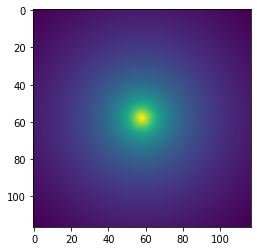

In [489]:
plt.imshow(call_model(np.concatenate(([1], 1/9 * psf_model.get_default_optpars()))))

In [501]:
# call_model(np.concatenate(([1], 1/9 * psf_model.get_default_optpars()))).numpy()

In [509]:
sopt.minimize(loss, np.concatenate(([10], 1/9 * psf_model.get_default_optpars())))

      fun: nan
 hess_inv: array([[ 1.03194897, -0.0538315 , -0.0275116 , -0.03330748,  0.68414725],
       [-0.0538315 ,  0.89024221, -0.01451425, -0.11579246, -1.96557882],
       [-0.0275116 , -0.01451425,  1.00520775, -0.02351957, -0.83594507],
       [-0.03330748, -0.11579246, -0.02351957,  0.88729227, -1.41032862],
       [ 0.68414725, -1.96557882, -0.83594507, -1.41032862, 12.35415284]])
      jac: array([nan, nan, nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 270
      nit: 2
     njev: 45
   status: 2
  success: False
        x: array([ 302.47212005, -971.59959117, -397.27337593, -715.51463098,
       4321.06928718])

In [518]:
 nll = lambda psf_val: torch.sum((psf_val - torch.tensor(prf)) ** 2)
 def loss_and_grad_fn(params):
    params = torch.tensor(params, requires_grad=True)
    flux = params[0]
    optpars = params[1:]
    mean_val = psf_model(flux, 58, 58, optpars)
    loss = nll(mean_val)
    gradient = tgrad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()

In [519]:
loss_and_grad_fn(np.concatenate(([10], 1/9 * psf_model.get_default_optpars())))

(array(8.19231913),
 array([-0.01478958, -0.01212665,  0.00148648, -0.01635187, -0.46691822]))

In [503]:
psf

tensor([[-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        ...,
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004]],
       dtype=torch.float64)

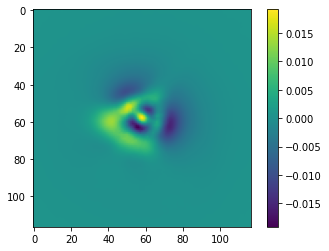

In [504]:
plt.imshow(prf - moffat(res.x))
plt.colorbar()

array([[0.06278269, 0.09044558, 0.10983737, 0.10904321, 0.08857761],
       [0.09626005, 0.14619155, 0.17835994, 0.17961598, 0.14980245],
       [0.12132604, 0.18358393, 0.21179807, 0.21351345, 0.19391291],
       [0.12104354, 0.18555   , 0.21382437, 0.21564781, 0.20175696],
       [0.09561137, 0.15198797, 0.19113265, 0.19863021, 0.17699485]])

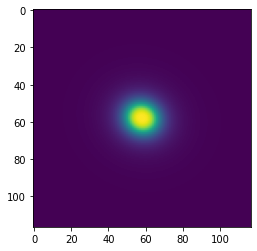

In [469]:
plt.imshow(moffat(res.x))